In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
from datasets import load_dataset, load_from_disk

dataset = load_dataset('lambdalabs/pokemon-blip-captions')

In [3]:
dataset.get('train')

Dataset({
    features: ['image', 'text'],
    num_rows: 833
})

In [4]:
dataset.get('train')[110]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x1280>,
 'text': 'a cartoon monkey flying with a bone in its mouth'}

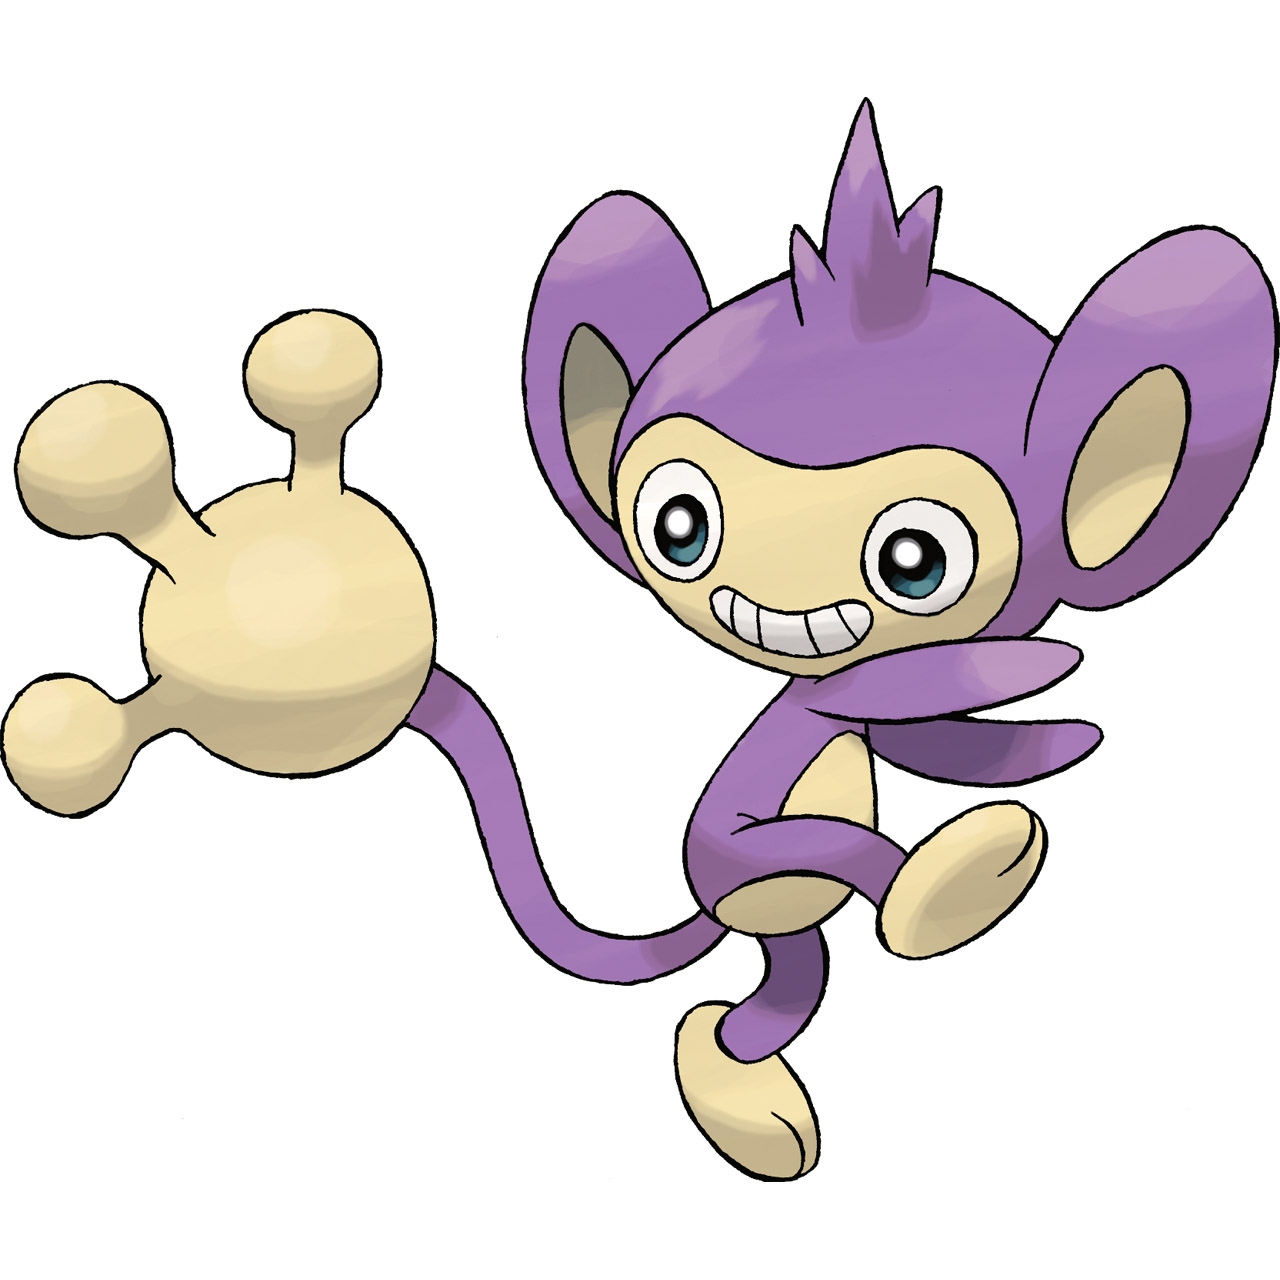

In [5]:
display(dataset.get('train')[110]['image'])

In [6]:
from transformers import GPT2TokenizerFast
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np

In [7]:
BATCH_SIZE = 1
CONTEXT_SIZE = 128
PAD_TOKEN = '[PAD]'
IMAGE_SIZE = 128

In [8]:

tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
# tokenizer.add_special_tokens({"pad_token": PAD_TOKEN})
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'right'


# def resize_images(batch):
#     # Specify your target size
#     target_size = (224, 224)
#     # Load the image
#     image = Image.open(batch['image_path'])
#     # Resize the image
#     image = image.resize(target_size)
#     # Convert the image to a numpy array and normalize pixel values to [0, 1]
#     batch['image'] = np.array(image) / 255.0
#     return batch

# def tokenize_and_pad_texts(batch):
#     # Tokenize the texts
#     tokenized_batch = tokenizer(batch['text'], padding='longest', truncation=True, max_length=CONTEXT_SIZE)
#     return tokenized_batch

train_transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ToTensor(),  # NOTE: This shuffles from (H, W, C) to (C, H, W)
        transforms.Normalize([0.5], [0.5]),  # TODO(2): Adjust normalization if needed. Can do linear transformation using transforms.lambda
    ]
)

# pil_transformer = transforms.Compose(
#     transforms.ToPILImage(),
# )

def tokenize_and_resize(examples):
    tokenizer_output = tokenizer(examples['text'], padding='max_length', truncation=True, max_length=CONTEXT_SIZE)
    return {
        'input_ids': tokenizer_output['input_ids'],
        'attention_mask': tokenizer_output['attention_mask'],
        'image': train_transforms(examples['image']),
    } 

# train_dataset = dataset['train'].map(tokenize_and_resize).with_format('torch')

train_dataset = load_from_disk(f"./data/pokemon_train_dataset_{IMAGE_SIZE}.hf")

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)

In [9]:
# train_dataset.save_to_disk(f"./data/pokemon_train_dataset_{IMAGE_SIZE}.hf")

In [10]:
# train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)

In [11]:
print(tokenizer.pad_token_id)

50256


In [12]:
next(iter(train_loader))

{'image': tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],
 
          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],
 
          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]]]),
 'text': ['a drawing of a cartoon character holding a tennis racket'],
 'input_ids': tensor([[   64,  8263,   286,   257, 16251,  2095,  4769,   257, 20790, 37

In [13]:
next(iter(train_loader)).keys()

dict_keys(['image', 'text', 'input_ids', 'attention_mask'])

In [14]:
next(iter(train_loader))['image'].dtype

torch.float32

In [29]:
import torch
import os
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

NUM_EPOCHS = 4096
LEARNING_RATE = 1e-4
NUM_DIFFUSION_TIMESTEPS = 1000
LATENT_DIM = IMAGE_SIZE // 8

In [30]:
import torch.nn as nn
import torch.nn.functional as F

In [20]:
from diffusers import DDPMScheduler
from diffusers.optimization import get_constant_schedule
from model import LLourney

model = LLourney()
model.to(DEVICE)
scheduler = DDPMScheduler(num_train_timesteps=NUM_DIFFUSION_TIMESTEPS)

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
lr_schedule = get_constant_schedule(optimizer)

In [21]:
thing = next(iter(train_loader))
elimage = thing['image']
eltext_id = thing["input_ids"]
elpad_mask = thing["attention_mask"]

In [22]:
elimage = torch.stack([thing['image'][0]] * BATCH_SIZE, dim=0).to(DEVICE)
eltext_id = torch.stack([thing['input_ids'][0]] * BATCH_SIZE, dim=0).to(DEVICE)
elpad_mask = torch.stack([thing['attention_mask'][0]] * BATCH_SIZE, dim=0).to(DEVICE)
print(elimage.shape)
print(eltext_id.shape)
print(elpad_mask.shape)

torch.Size([1, 3, 128, 128])
torch.Size([1, 128])
torch.Size([1, 128])


In [ ]:
# TRAINING LOOP
# Load checkpoint if available
# CHECKPOINT_FILE_PATH = "model_checkpoint_1img_small_train.pt"
# if os.path.isfile(CHECKPOINT_FILE_PATH):
#     print(f"Loading checkpoint from {CHECKPOINT_FILE_PATH}")
#     checkpoint = torch.load(CHECKPOINT_FILE_PATH)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.train()
step_i = 0
for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    for step, batch in enumerate(train_loader):
        step_i += 1
        #image = batch["image"].to(DEVICE)
        #text_id = batch["input_ids"].to(DEVICE)
        #pad_mask = batch["attention_mask"].to(DEVICE)
        image = elimage
        text_id = eltext_id
        pad_mask = elpad_mask
        batch_size = image.shape[0]

        # Use VAE to encode image in latent space
        latent_image = model.encode_image(image)
        latent_image *= model.vae.config.scaling_factor
        assert latent_image.shape[-1] == LATENT_DIM

        # Sample gaussian with same shape as latent image
        Z = torch.randn_like(latent_image).to(DEVICE)

        # Sample timesteps, one for each item in the batch
        T = torch.randint(0, NUM_DIFFUSION_TIMESTEPS, (batch_size,)).to(DEVICE)
        T = T.long()

        # Transform input images to noisy images now
        noisy_latent_image = scheduler.add_noise(latent_image, Z, T)

        # Use the model to predict the noise
        denoised_latent_noise = model(noisy_latent_image, text_id, T, text_pad_mask=pad_mask)

        # Calculate the loss
        loss_node = F.mse_loss(denoised_latent_noise.float(), Z, reduction='mean')

        # Backpropagate
        loss_node.backward()
        optimizer.step()
        lr_schedule.step()
        optimizer.zero_grad()

        if step_i % 100 == 0:
            print(f'step_{step_i}: {loss_node.item()}')

        

step_100: 0.7321271896362305
step_200: 0.758507490158081
step_300: 0.6794930696487427
step_400: 0.7992520332336426
step_500: 0.7785888314247131
step_600: 0.7162675857543945
step_700: 0.732684850692749
step_800: 0.6745902299880981
step_900: 0.7817003726959229
step_1000: 0.7911816835403442
step_1100: 0.7360568046569824
step_1200: 0.7243735790252686
step_1300: 0.7462912797927856
step_1400: 0.810820460319519
step_1500: 0.6807833313941956
step_1600: 0.7199708223342896
step_1700: 0.7021163105964661
step_1800: 0.7049993872642517
step_1900: 0.7325210571289062
step_2000: 0.7096971273422241
step_2100: 0.7266859412193298
step_2200: 0.6870906949043274
step_2300: 0.657416582107544
step_2400: 0.7388735413551331
step_2500: 0.7342798709869385
step_2600: 0.7412891983985901
step_2700: 0.7223604917526245
step_2800: 0.7390109300613403
step_2900: 0.8258435726165771
step_3000: 0.8247244358062744
step_3100: 0.7444107532501221
step_3200: 0.7467533349990845
step_3300: 0.6563479900360107
step_3400: 0.6666101813

In [ ]:
# Save checkpoint
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, "model_checkpoint_1img_small_train.pt")

In [26]:
NUM_INFERENCE_STEPS = 100

In [27]:
thing['text'][0]

'a drawing of a dragon sitting on its hind legs'

Latent noise shape: torch.Size([1, 4, 16, 16])
torch.Size([1, 4, 16, 16])


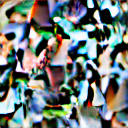

In [28]:
from diffusers.pipelines.pipeline_utils import numpy_to_pil
from diffusers import DDPMScheduler

from model import LLourney

from PIL import Image

# model = LLourney()

inprogress = []

def encode_prompt(prompt):
    tokenizer_output = tokenizer(prompt, padding='max_length', truncation=True, max_length=CONTEXT_SIZE)
    input_ids = torch.LongTensor(tokenizer_output["input_ids"]).to(DEVICE)
    attention_mask = torch.Tensor(tokenizer_output["attention_mask"]).to(DEVICE)
    return input_ids, attention_mask

def generate(prompt: str) -> Image:
    model.eval()
    prompt = [prompt]
    Z = torch.randn(len(prompt), 4, LATENT_DIM, LATENT_DIM, device=DEVICE)
    scheduler.set_timesteps(NUM_INFERENCE_STEPS)
    timesteps = scheduler.timesteps

    input_ids, attention_mask = encode_prompt(prompt)
    latent_images = Z
    print(f"Latent noise shape: {latent_images.shape}")
    
    for i, t in enumerate(timesteps):
        latent_images = scheduler.scale_model_input(latent_images, t)
        batched_t = torch.cat([torch.tensor([t])] * len(prompt), dim=0).to(DEVICE)
        
        model_output = model(latent_images, input_ids, batched_t, text_pad_mask=attention_mask)
        latent_images = scheduler.step(model_output, t, latent_images, return_dict=False)[0]

        decoded_imagess = model.decode_image_latents(latent_images)
        image = [numpy_to_pil(img) for img in decoded_imagess]
        inprogress.append(image[0][0])

    print(latent_images.shape)
    
    decoded_images = model.decode_image_latents(latent_images)
    image = [numpy_to_pil(img) for img in decoded_images]

    return image[0][0]

# Generate some images
image = generate(thing['text'][0])
display(image)

# print(latent_images.shape)
# decoded_images = model.decode_image_latents(latent_images)
# image = [numpy_to_pil(img) for img in decoded_images]

# # Generate some images
# prompt = ["pokeymans", "big dog with cricket bat"]
# Z = torch.randn(len(prompt), 4, LATENT_DIM, LATENT_DIM, device=DEVICE)
# scheduler = DDPMScheduler(num_train_timesteps=NUM_TRAIN_TIMESTEPS)
# scheduler.set_timesteps(NUM_INFERENCE_STEPS)
# timesteps = scheduler.timesteps

# def encode_prompt(prompt):
#     tokenizer_output = tokenizer(prompt, padding='max_length', truncation=True, max_length=CONTEXT_SIZE)
#     input_ids = torch.LongTensor(tokenizer_output["input_ids"]).to(DEVICE)
#     attention_mask = torch.Tensor(tokenizer_output["attention_mask"]).to(DEVICE)
#     return input_ids, attention_mask

# input_ids, attention_mask = encode_prompt(prompt)
# latent_images = Z
# print(f"Latent noise shape: {latent_images.shape}")
# for i, t in enumerate(timesteps):
#     batched_t = torch.cat([torch.tensor([t])] * len(prompt), dim=0)
#     print(f"Batched t shape: {batched_t.shape}")
#     print(f"Input ids 666: {input_ids.shape}")
#     print(f"Attention mask 666: {attention_mask.shape}")
#     model_output = model(latent_images, input_ids, batched_t, text_pad_mask=attention_mask)

#     latent_images = scheduler.step(model_output, t, latent_images).prev_sample

# print(latent_images.shape)
# decoded_images = model.decode_image_latents(latent_images)
# image = [numpy_to_pil(img) for img in decoded_images]

# display(image[0])


In [ ]:
latent_images = model.encode_image(thing["image"].to(DEVICE))
decoded_images = model.decode_image_latents(latent_images)
image = [numpy_to_pil(img) for img in decoded_images]

In [ ]:
display(image[0][0])

In [ ]:
for i in inprogress:
    display(i)

In [ ]:
import datetime

image.save(f"pred_img_{step_i}_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}")

In [ ]:
display(image)

In [ ]:
display(image[0][0])

In [ ]:
display(image[1][0])

In [ ]:
display(image[2][0])

In [ ]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler()

scheduler.set_timesteps(100)

timesteps = scheduler.timesteps

print(timesteps)
print(timesteps[0])

In [ ]:
model.llama.config.n_positions

In [ ]:
model.llama.config.n_embd